In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from scipy import interpolate
from datetime import datetime
print(os.getcwd())

%matplotlib ipympl

vapour = True

from jfunctions import *

/mhome/damtp/q/cwp29/diablo3/proc/jupyter


In [2]:
#Load simulation data
b, phi, Jv, Jc, K, times = load_data('th1_xz', 'th2_xz', 'b_phiv_mF2', 'b_phic_mF3', 'b_phic_sF3')
    
NSAMP = len(times)

# Load simulation metadata
md = get_metadata()

# Get dir locations from param file
base_dir, run_dir, save_dir, version = read_params('./params.dat')
print(base_dir)

bbins, phivbins = load_bins_moist(save_dir, True)
bbins, phicbins = load_bins_moist(save_dir, False)

times, t0_idx = calibrate_time(save_dir, times)


# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

Keys: <KeysViewHDF5 ['B_xy', 'B_xz', 'B_yz', 'Ent_phic_flux_int', 'Ent_phic_flux_rec', 'Ent_phiv_flux_int', 'Ent_phiv_flux_rec', 'N2_xy', 'N2_xz', 'N2_yz', 'Re_b_xy', 'Re_b_xz', 'Re_b_yz', 'Ri_xy', 'Ri_xz', 'Ri_yz', 'b_phic_F1', 'b_phic_F3', 'b_phic_M', 'b_phic_S', 'b_phic_W', 'b_phic_mF1', 'b_phic_mF3', 'b_phic_sF3', 'b_phiv_F1', 'b_phiv_F2', 'b_phiv_M', 'b_phiv_S', 'b_phiv_W', 'b_phiv_mF1', 'b_phiv_mF2', 'chi1_xy', 'chi1_xz', 'chi1_yz', 'chi2_xy', 'chi2_xz', 'chi2_yz', 'chi3_xy', 'chi3_xz', 'chi3_yz', 'diff_th1_xy', 'diff_th1_xz', 'diff_th1_yz', 'diff_th2_xy', 'diff_th2_xz', 'diff_th2_yz', 'diff_th3_xy', 'diff_th3_xz', 'diff_th3_yz', 'epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'kappa_t3_xy', 'kappa_t3_xz', 'kappa_t3_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz',

In [3]:
print(md)

{'LX': 0.6, 'LY': 0.6, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 5.0, 'VERSION': 3.12, 'NU_START_TIME': 5.0, 'r0': 0.002, 'alpha_e': 0.11, 'b0': 0.02, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.2, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.25, 'phiv_factor': 0.7, 'phic_factor': 3.0, 'Nb': 128.0, 'Nphi': 128.0, 'F_TYPE': 3.0, 'alpha': 67.0, 'beta': 0.51, 'tau': 0.1, 'q0': 0.1, 'phiv_min': 0.0001, 'phic_min': 0.0001, 'T': 10.0, 'Trelax': 0.5, 'w_s': 0.01, 'INIT_NOISE': 1e-08, 'shear_rate': 0.2, 'Nx': 512, 'Ny': 512, 'Nz': 513, 'Nth': 3}


In [4]:
#Create grids
X, Y = np.meshgrid(gx, gz)
Xf, Yf = np.meshgrid(gxf, gzf)

db = bbins[1] - bbins[0]
dphiv = phivbins[1] - phivbins[0]
dphic = phicbins[1] - phicbins[0]

sx_v, sy_v = np.meshgrid(np.append(bbins-db/2, bbins[-1]+db/2),
        np.append(phivbins - dphiv/2, phivbins[-1] + dphiv/2))
sxf_v, syf_v = np.meshgrid(bbins, phivbins)

sx_c, sy_c = np.meshgrid(np.append(bbins-db/2, bbins[-1]+db/2),
        np.append(phicbins - dphic/2, phicbins[-1] + dphic/2))
sxf_c, syf_c = np.meshgrid(bbins, phicbins)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 58
Dimensional times:  [-4.20119484 -3.95119484 -3.70119484 -3.45119484 -3.20119484 -2.95119484
 -2.70119484 -2.45119484 -2.20119484 -1.95119484 -1.70119484 -1.45119484
 -1.20119484 -0.95119484 -0.70119484 -0.45119484 -0.20119484  0.
  0.25        0.5         0.75        1.          1.25        1.5
  1.75        2.          2.25        2.5         2.75        3.
  3.25        3.5         3.75        4.          4.25        4.5
  4.75        5.          5.25        5.5         5.75        6.
  6.25        6.5         6.75        7.          7.25        7.5
  7.75        8.          8.25        8.5         8.75        9.
  9.25        9.5         9.75       10.        ]


In [5]:
# Set-up
Jv = np.where(Jv == 0, np.NaN, Jv)
Jc = np.where(Jc == 0, np.NaN, Jc)
K = np.where(K == 0, np.NaN, K)

# Non-dimensionalising
F0 = compute_F0(save_dir, md, tstart_ind = 2*4, verbose=False, zbot=0.7, ztop=0.95, plot=False, moist=True, vapour=vapour)
N = np.sqrt(md['N2'])
T = np.power(N, -1)
L = np.power(F0, 1/4) * np.power(N, -3/4)

# CURRENTLY OMITTED!

In [6]:
# Thresholding
tracer_thresh = phivbins[0]-dphiv/2
tracer_thresh_low = 1e-3
plot_plume = np.where(
        np.logical_or(
            np.logical_and(phi > tracer_thresh_low, Yf < md['H']-L),
            np.logical_and(phi > tracer_thresh, Yf >= md['H']-L)),
        phi, np.NaN)
plot_env = np.where(np.logical_and(np.isnan(plot_plume), Yf >= md['H']-L), b, np.NaN)

b = np.where(b < 1e-5, 0, b)

In [7]:
# Create colourmaps
S_bounds = np.linspace(-1e-6,  1e-6, 9)
S_norm = colors.BoundaryNorm(boundaries=S_bounds, ncolors=256)

colors_red = plt.cm.coolwarm(np.linspace(0.53, 1, 32))
colors_blue = plt.cm.coolwarm(np.linspace(0, 0.47, 32))
all_colors = np.vstack((colors_blue, colors_red))
custom_cmap = colors.LinearSegmentedColormap.from_list("cmap", all_colors)

In [8]:
# Set plot limits and contours
bmax_plot = bbins[-1]
phivmax_plot = phivbins[-1]
phicmax_plot = phicbins[-1]

contours_b = np.linspace(1e-5, bmax_plot, 100)[1::10]
contours_phi = np.linspace(phivbins[0] - dphiv/2, phivmax_plot, 10)
mid_tracer_thresh = contours_phi[2]

In [9]:
# Compute zmax
tracer_data_vert = np.where(phi[:, :, int(md['Nx']/2)] >= mid_tracer_thresh,
        phi[:, :, int(md['Nx']/2)], 0)
plume_vert = np.where(tracer_data_vert >= mid_tracer_thresh, 1, 0)
#heights = []
#for i in range(len(plume_vert)):
    #stuff = np.where(plume_vert[i] == 1)[0]
    #if len(stuff) == 0:
        #heights.append(0)
    #else:
        #heights.append(gzf[np.max(stuff)+1])

In [10]:
def sat_curves(ax, bs, z, col):
    ax.plot(bs, md['q0'] * np.exp(md['alpha'] * (bs - md['beta']*z)), color=col, ls='--', alpha=0.3)

In [11]:
def decorate(fig, axs, step):
    fig.suptitle("t = {0:.2f} s".format(times[step]))

    for a in [axs[0,1]]:
        a.set_xlim(bbins[0]-db/2, bmax_plot)
        a.set_ylim(phivbins[0]-dphiv/2, phivmax_plot)

        a.set_xlabel(r"$b$")
        a.set_ylabel(r"$\phi_v$")
        
    for a in [axs[1,0], axs[1,1]]:
        a.set_xlim(bbins[0]-db/2, bmax_plot)
        a.set_ylim(phicbins[0]-dphic/2, phicmax_plot)

        a.set_xlabel(r"$b$")
        a.set_ylabel(r"$\phi_c$")

    axs[0,0].set_xlim(0, 0.4)
    axs[0,0].set_aspect(1)
    axs[0,0].set_ylim(md['H']-L, md['H']+7*L)
    axs[0,0].set_xlabel(r"$x$")
    axs[0,0].set_ylabel(r"$z$")

    im_phi.set_clim(phivbins[0]-dphiv/2, phivmax_plot)
    cont_phi.set_clim(phivbins[0]-dphiv/2, phivmax_plot)

    axs[0,0].set_title(r"(a) tracer field $\phi$")
    axs[0,1].set_title(r"(b) vapour saturation flux")
    axs[1,0].set_title(r"(c) condensate saturation flux")
    axs[1,1].set_title(r"(d) sedimentation flux")


In [12]:
def decorate_cb(fig, axs, step):
    cb_env = fig.colorbar(im_b_edge, ax=axs[0,0], location='right', shrink=0.8)
    cb_env.set_label(r"$b$", rotation=0, labelpad=5)

    cb_plume = fig.colorbar(im_phi, ax = axs[0,0], location='right', shrink=0.8, extend='max')
    cb_plume.set_label(r"$\phi$", rotation=0, labelpad=5)

    cb_Jv = fig.colorbar(im_Jv, ax = axs[0,1], location='right', shrink=0.8)
    cb_Jv.set_label("$J_v$", rotation=0, labelpad=5)
    
    cb_Jc = fig.colorbar(im_Jc, ax = axs[1,0], location='right', shrink=0.8)
    cb_Jc.set_label("$J_c$", rotation=0, labelpad=5)
    
    cb_K = fig.colorbar(im_K, ax = axs[1,1], location='right', shrink=0.8)
    cb_K.set_label("$K$", rotation=0, labelpad=5)

In [13]:
def plots(fig, axs, step):
    global im_b_edge, im_phi, cont_phi, im_Jv, im_Jc, im_K

    im_b_edge = axs[0,0].contour(Xf, Yf, plot_env[step], levels=contours_b, cmap='cool', alpha=0.8)
    im_phi = axs[0,0].pcolormesh(X, Y, plot_plume[step], cmap='viridis', alpha=0.5)
    cont_phi = axs[0,0].contour(Xf, Yf, plot_plume[step], cmap='viridis', levels=contours_phi, ls='--')

    im_Jv = axs[0,1].pcolormesh(sx_v, sy_v, Jv[step], cmap='bwr', norm=colors.CenteredNorm(halfrange=1e-7))
    im_Jc = axs[1,0].pcolormesh(sx_c, sy_c, Jc[step], cmap='bwr', norm=colors.CenteredNorm(halfrange=1e-7))
    im_K = axs[1,1].pcolormesh(sx_c, sy_c, K[step], cmap='bwr', norm=colors.CenteredNorm(halfrange=1e-6))

    b_to_z = interpolate.interp1d(b[0,:,10], gzf)
    b_cmap = im_b_edge.get_cmap()
    for b_val in contours_b[:5]:
        print(b_val)
        sat_curves(axs[0,1], bbins, b_to_z(b_val), b_cmap((b_val-contours_b[0])/(contours_b[-1]-contours_b[0])))
        sat_curves(axs[1,0], bbins, b_to_z(b_val), b_cmap((b_val-contours_b[0])/(contours_b[-1]-contours_b[0])))
        sat_curves(axs[1,1], bbins, b_to_z(b_val), b_cmap((b_val-contours_b[0])/(contours_b[-1]-contours_b[0])))

    decorate(fig, axs, step)

/tmp/ipykernel_49038/632700129.py:6: UserWarning: The following kwargs were not used by contour: 'ls'
  cont_phi = axs[0,0].contour(Xf, Yf, plot_plume[step], cmap='viridis', levels=contours_phi, ls='--')


0.0010160542929292928
0.01107659722222222
0.021137140151515146
0.031197683080808076
0.041258226010101005


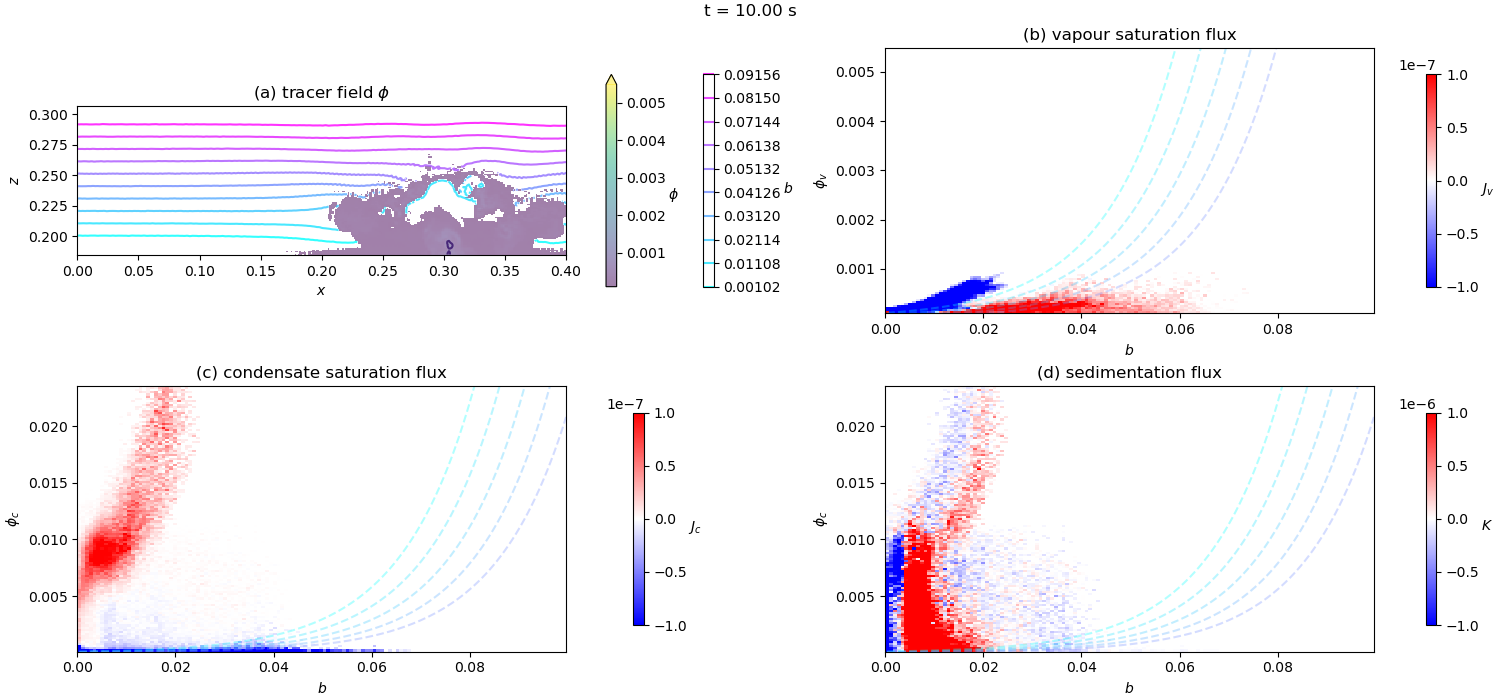

In [14]:
# Plotting loop
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(15, 7))

plots(fig, axs, -1)
decorate_cb(fig, axs, -1)

def animate(step):
    for a in axs.ravel():
        a.clear()

    plots(fig, axs, step)
    decorate(fig, axs, step)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=-1)

anim = animation.FuncAnimation(fig, animate, interval=250, frames=list(range(t0_idx, NSAMP)), repeat=True)
now = datetime.now()
#anim.save(save_dir+'scatter_%s.mp4'%now.strftime("%d-%m-%Y"),writer=writer)
plt.show()